In [12]:
# Import all libraries needed for the entire notebook
# pandas: data manipulation and loading CSVs
# numpy: numerical operations
# matplotlib/seaborn: plotting
# warnings: suppress harmless deprecation messages that clutter output

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# darkgrid adds subtle grid lines making charts easier to read
sns.set_style('darkgrid')

# default figure size for all plots
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 12

# show all columns when printing dataframes, not truncated with ...
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Libraries loaded successfully")

Libraries loaded successfully


In [13]:
# Load the raw CSV generated by generate_access_logs.py
# Parse timestamp immediately on load - every temporal analysis depends
# on this being a datetime object, not a plain string
df = pd.read_csv('../data/raw/enterprise_privileged_access_logs.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Quick sanity check - confirm the file loaded correctly
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"Date range: {df['timestamp'].min()} → {df['timestamp'].max()}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Preview the first 5 rows
df.head()

Shape: (12918, 10)
Columns: ['user_id', 'role', 'resource_type', 'action', 'timestamp', 'session_duration', 'access_volume', 'success_flag', 'assigned_resource_count', 'actively_used_resource_count']
Date range: 2024-01-01 00:35:20 → 2024-12-30 23:58:49
Memory usage: 3.4 MB


,user_id,role,resource_type,action,timestamp,session_duration,access_volume,success_flag,assigned_resource_count,actively_used_resource_count
0,USER_045,Cloud_Admin,gcp_console,read,2024-01-01 00:35:20,42.0,17.0,True,9,8
1,USER_055,Cloud_Admin,iam_console,write,2024-01-01 00:57:24,57.0,14.0,True,7,5
2,USER_064,Security_Admin,firewall_portal,write,2024-01-01 01:32:34,61.0,20.0,True,7,5
3,USER_024,HR_Admin,TIME_TRACKING,read,2024-01-01 01:54:39,31.0,7.0,True,5,4
4,USER_044,Cloud_Admin,gcp_console,Export,2024-01-01 02:38:32,75.0,16.0,True,9,7


In [14]:
# df.info() gives you three critical things at once:
# 1. The dtype of each column (int, float, object, datetime)
# 2. Non-null count per column - this immediately reveals missing values
# 3. Memory usage
# This is always the first thing to run on any new dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12918 entries, 0 to 12917
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   user_id                       12918 non-null  object        
 1   role                          12918 non-null  object        
 2   resource_type                 12918 non-null  object        
 3   action                        12918 non-null  object        
 4   timestamp                     12918 non-null  datetime64[ns]
 5   session_duration              12535 non-null  float64       
 6   access_volume                 12528 non-null  float64       
 7   success_flag                  12918 non-null  bool          
 8   assigned_resource_count       12918 non-null  int64         
 9   actively_used_resource_count  12918 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 921.0+ KB


In [15]:
# Count nulls per column and express as both raw count and percentage
# .query() filters to only show columns that actually have missing values
# so the output stays clean instead of showing 0s for everything

missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    'missing_count': missing,
    'missing_pct': missing_pct
}).query('missing_count > 0')

print("=== MISSING VALUES ===")
print(missing_df)
print(f"\nTotal missing cells: {df.isnull().sum().sum()}")
print(f"Total cells in dataset: {df.shape[0] * df.shape[1]:,}")

=== MISSING VALUES ===
                  missing_count  missing_pct
session_duration            383         2.96
access_volume               390         3.02

Total missing cells: 773
Total cells in dataset: 129,180


In [16]:
# Check for exact duplicate rows - the generator intentionally added ~2%
# keep=False marks ALL copies of a duplicate so you can see both the 
# original and its copy side by side, making the problem obvious

dupe_count = df.duplicated().sum()
print(f"Duplicate rows: {dupe_count} ({dupe_count/len(df)*100:.2f}%)")

print("\nSample of duplicate pairs:")
# Sort by user_id so duplicates appear next to each other
df[df.duplicated(keep=False)].sort_values(
    ['user_id', 'timestamp']
).head(6)

Duplicate rows: 148 (1.15%)

Sample of duplicate pairs:


,user_id,role,resource_type,action,timestamp,session_duration,access_volume,success_flag,assigned_resource_count,actively_used_resource_count
11117,USER_001,DB_Admin,staging_db,read,2024-11-15 15:14:18,80.0,9.0,True,8,6
11118,USER_001,DB_Admin,staging_db,read,2024-11-15 15:14:18,80.0,9.0,True,8,6
665,USER_002,DB_Admin,data_lake,write,2024-01-20 07:42:33,68.0,13.0,True,11,9
666,USER_002,DB_Admin,data_lake,write,2024-01-20 07:42:33,68.0,13.0,True,11,9
5972,USER_002,DB_Admin,staging_db,delete,2024-06-24 09:41:01,63.0,6.0,True,11,9
5973,USER_002,DB_Admin,staging_db,delete,2024-06-24 09:41:01,63.0,6.0,True,11,9


In [17]:
# The generator uppercased ~10% of resource_type values
# e.g. 'prod_database' became 'PROD_DATABASE'
# str.isupper() returns True only for fully uppercase strings

# First print raw unique values so you can SEE the problem directly
print("Sample of unique resource_type values (raw):")
print(sorted(df['resource_type'].unique())[:20])

# Then quantify how many rows are affected
uppercase_mask = df['resource_type'].str.isupper()
print(f"\nUppercase resource_type rows: {uppercase_mask.sum()} "
      f"({uppercase_mask.mean()*100:.1f}%)")

# Show examples of the inconsistency
print("\nExamples of uppercase entries:")
print(df[uppercase_mask]['resource_type'].value_counts().head(10))

Sample of unique resource_type values (raw):
['ACCESS_REVIEW', 'ANALYTICS_DB', 'ANSIBLE_TOWER', 'API_GATEWAY', 'ARCHIVE_DB', 'ARTIFACT_REGISTRY', 'AUDIT_LOGS', 'AWS_CONSOLE', 'AZURE_PORTAL', 'BACKUP_DB', 'BENEFITS_PORTAL', 'CDN_MANAGER', 'CI_CD_CONSOLE', 'CLOUDWATCH', 'COMPENSATION_DB', 'COMPLIANCE_PORTAL', 'COST_EXPLORER', 'DATA_LAKE', 'DATA_WAREHOUSE', 'DEPLOYMENT_MANAGER']

Uppercase resource_type rows: 1291 (10.0%)

Examples of uppercase entries:
resource_type
PERFORMANCE_SYSTEM      45
INCIDENT_RESPONSE       40
MONITORING_DASHBOARD    40
QUERY_TOOL              40
PAYROLL_SYSTEM          35
DEV_DATABASE            33
DATA_LAKE               32
GCP_CONSOLE             32
FIREWALL_PORTAL         32
JENKINS_PIPELINE        32
Name: count, dtype: int64


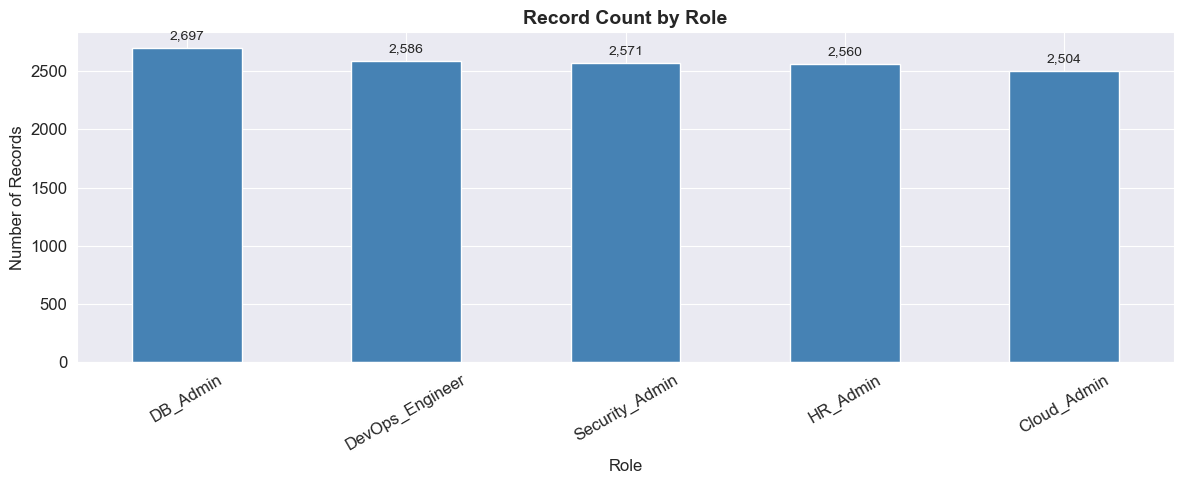

role
DB_Admin           2697
DevOps_Engineer    2586
Security_Admin     2571
HR_Admin           2560
Cloud_Admin        2504
Name: count, dtype: int64


In [18]:
# Strip whitespace before counting so all 'HR_Admin' variants 
# are counted together, giving accurate role totals
# Without .str.strip() this chart would show doubled bars for each role

role_counts = df['role'].str.strip().value_counts()

fig, ax = plt.subplots()
role_counts.plot(kind='bar', ax=ax, color='steelblue', edgecolor='white')
ax.set_title('Record Count by Role', fontsize=14, fontweight='bold')
ax.set_xlabel('Role')
ax.set_ylabel('Number of Records')
ax.tick_params(axis='x', rotation=30)

# Add the exact count above each bar so you don't have to guess from the axis
for bar in ax.patches:
    ax.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 50,
        f'{int(bar.get_height()):,}',
        ha='center', va='bottom', fontsize=10
    )

plt.tight_layout()
plt.show()

print(role_counts)

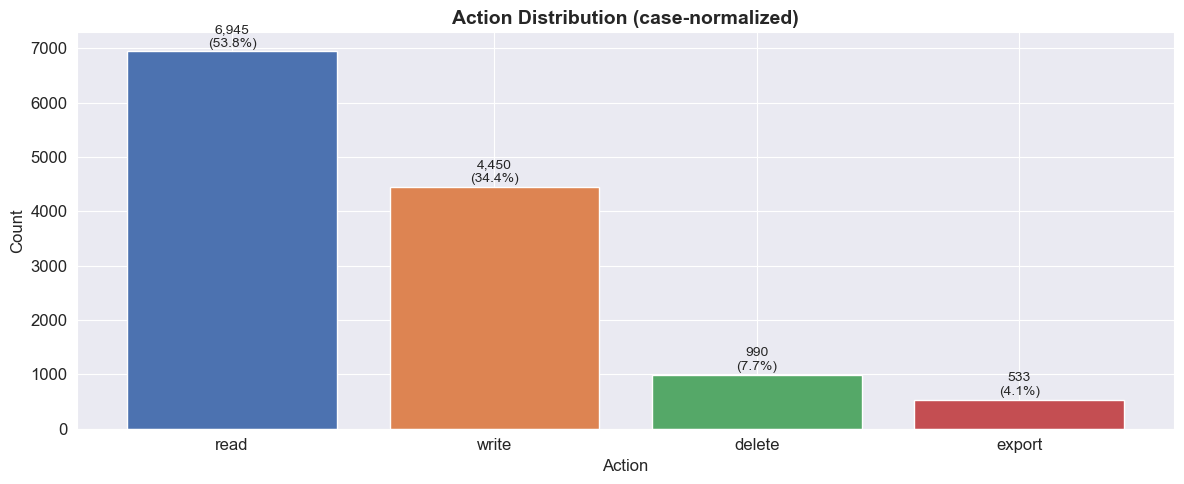

In [19]:
# Normalize to lowercase before counting so 'read' and 'Read' 
# are treated as the same action - otherwise the chart would show 8 bars
# instead of 4, making exports look even rarer than they are

action_counts = df['action'].str.lower().value_counts()

fig, ax = plt.subplots()
# Different colors per action makes it easier to reference in discussion
bars = ax.bar(
    action_counts.index, 
    action_counts.values,
    color=['#4C72B0', '#DD8452', '#55A868', '#C44E52'],
    edgecolor='white'
)
ax.set_title('Action Distribution (case-normalized)', fontsize=14, fontweight='bold')
ax.set_ylabel('Count')
ax.set_xlabel('Action')

# Add count AND percentage above each bar
for bar in bars:
    height = int(bar.get_height())
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 30,
        f'{height:,}\n({height/len(df)*100:.1f}%)',
        ha='center', va='bottom', fontsize=10
    )

plt.tight_layout()
plt.show()

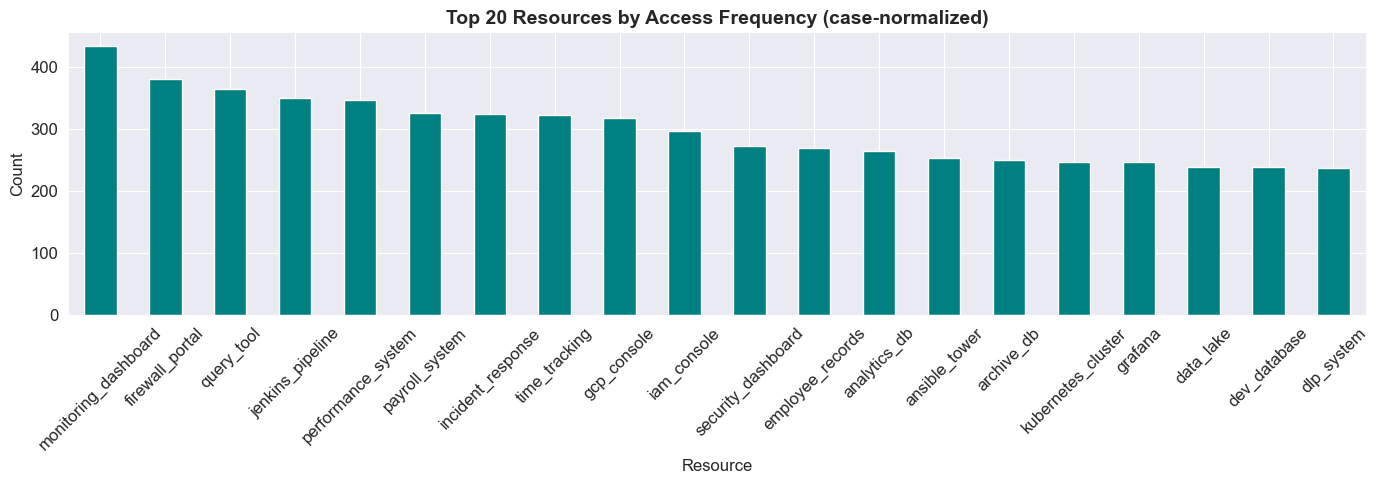

Total unique resources (case-normalized): 60

Top 10 most accessed resources:
resource_type
monitoring_dashboard    435
firewall_portal         382
query_tool              366
jenkins_pipeline        351
performance_system      347
payroll_system          327
incident_response       325
time_tracking           324
gcp_console             319
iam_console             298
Name: count, dtype: int64


In [20]:
# Normalize to lowercase before counting (same reason as cell 11)
# Show only top 20 - there are 60 unique resources total so showing all
# would make the chart unreadable

resource_counts = df['resource_type'].str.lower().value_counts()

fig, ax = plt.subplots(figsize=(14, 5))
resource_counts.head(20).plot(
    kind='bar', ax=ax, color='teal', edgecolor='white'
)
ax.set_title('Top 20 Resources by Access Frequency (case-normalized)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Resource')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Print total unique to confirm all 60 resources are present
total_unique = df['resource_type'].str.lower().nunique()
print(f"Total unique resources (case-normalized): {total_unique}")
print(f"\nTop 10 most accessed resources:")
print(resource_counts.head(10))

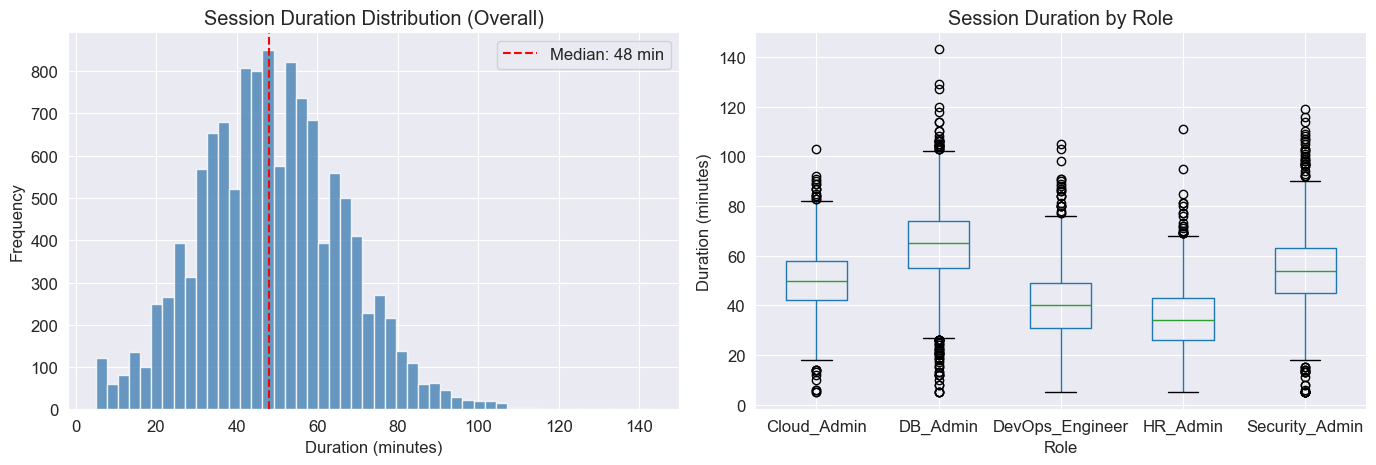

Session Duration Statistics:
count    12535.0
mean        48.7
std         17.8
min          5.0
25%         36.0
50%         48.0
75%         60.0
max        143.0
Name: session_duration, dtype: float64


In [21]:
# dropna() required because ~3% of session_duration values are null
# Plotting with nulls would either error or silently drop them anyway,
# but explicit is better - you know you're aware of the missing data

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LEFT: Overall distribution - reveals the shape and any outliers
axes[0].hist(
    df['session_duration'].dropna(), 
    bins=50, color='steelblue', edgecolor='white', alpha=0.8
)
axes[0].set_title('Session Duration Distribution (Overall)')
axes[0].set_xlabel('Duration (minutes)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df['session_duration'].median(), color='red', 
                linestyle='--', label=f"Median: {df['session_duration'].median():.0f} min")
axes[0].legend()

# RIGHT: By role - reveals the programmed baseline differences per role
# Must strip whitespace first or roles won't group correctly
df_clean_role = df.copy()
df_clean_role['role'] = df_clean_role['role'].str.strip()

df_clean_role.boxplot(column='session_duration', by='role', ax=axes[1])
axes[1].set_title('Session Duration by Role')
axes[1].set_xlabel('Role')
axes[1].set_ylabel('Duration (minutes)')
plt.suptitle('')  # removes matplotlib's auto-generated title which overlaps

plt.tight_layout()
plt.show()

print("Session Duration Statistics:")
print(df['session_duration'].describe().round(1))

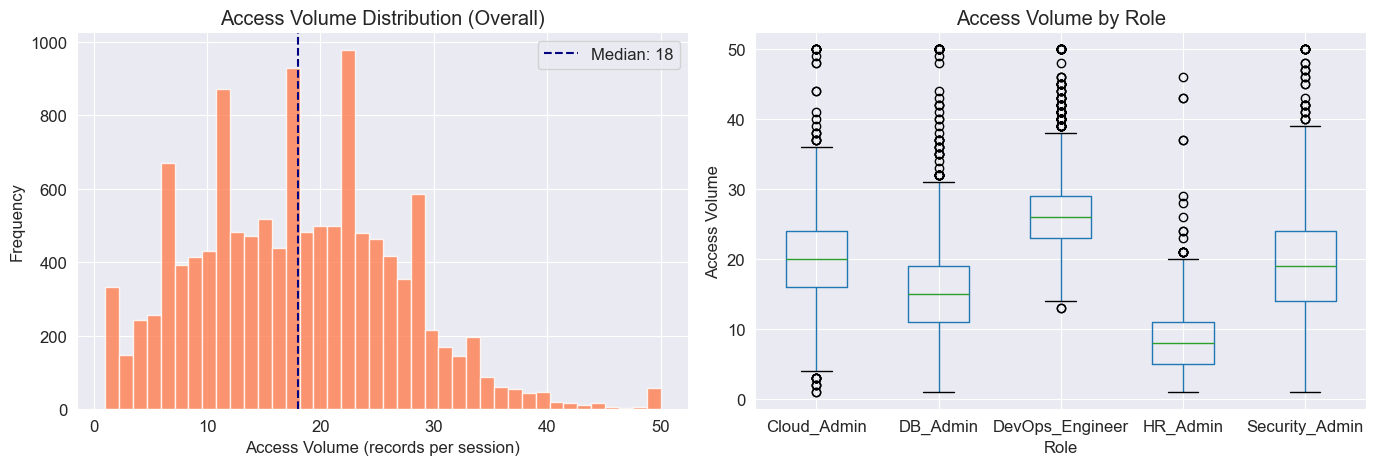

Access Volume Statistics:
count    12528.0
mean        18.0
std          9.0
min          1.0
25%         11.0
50%         18.0
75%         24.0
max         50.0
Name: access_volume, dtype: float64

Spike events (>mean+3SD, volume>45): 83 records


In [22]:
# Same structure as cell 13 - overall distribution then by role
# access_volume measures how many files/records were accessed per session

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(
    df['access_volume'].dropna(),
    bins=40, color='coral', edgecolor='white', alpha=0.8
)
axes[0].set_title('Access Volume Distribution (Overall)')
axes[0].set_xlabel('Access Volume (records per session)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(
    df['access_volume'].median(), color='navy',
    linestyle='--', label=f"Median: {df['access_volume'].median():.0f}"
)
axes[0].legend()

df_clean_role.boxplot(column='access_volume', by='role', ax=axes[1])
axes[1].set_title('Access Volume by Role')
axes[1].set_xlabel('Role')
axes[1].set_ylabel('Access Volume')
plt.suptitle('')

plt.tight_layout()
plt.show()

print("Access Volume Statistics:")
print(df['access_volume'].describe().round(1))

# Specifically check for spike events the generator programmed
# gradually_drifting users have a 5% chance of 2-3x spikes
spike_threshold = df['access_volume'].mean() + 3 * df['access_volume'].std()
spike_count = (df['access_volume'] > spike_threshold).sum()
print(f"\nSpike events (>mean+3SD, volume>{spike_threshold:.0f}): {spike_count} records")

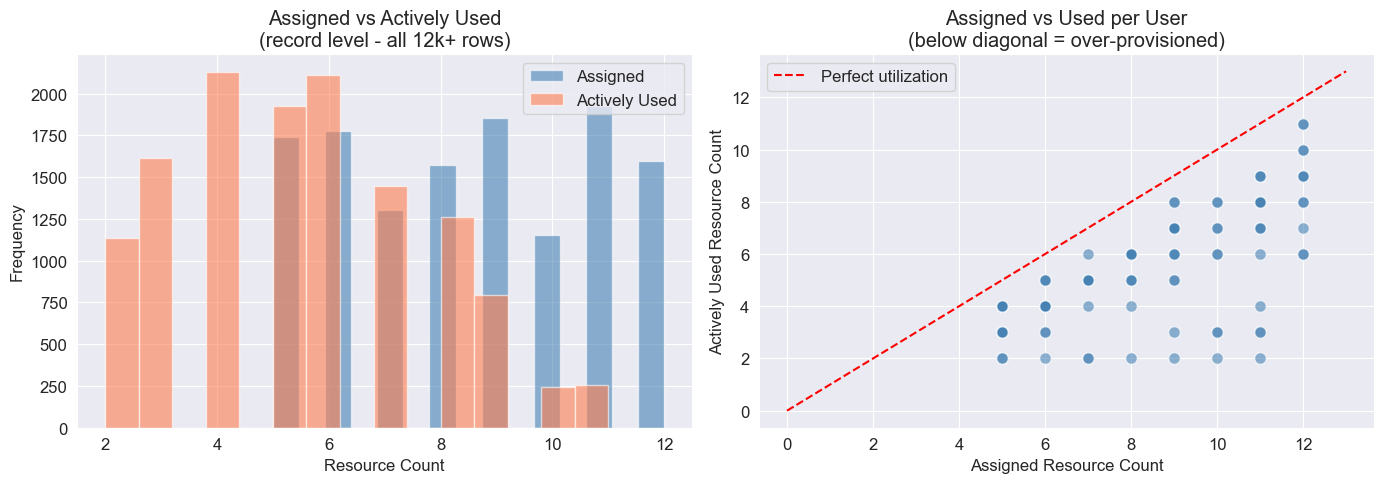

Users not using all assigned resources: 100/100

User-level stats:
       assigned   used
count     100.0  100.0
mean        8.4    5.4
std         2.4    2.2
min         5.0    2.0
25%         6.0    4.0
50%         8.5    5.0
75%        11.0    7.0
max        12.0   11.0


In [23]:
# This is the most conceptually important chart in the notebook
# The whole dataset is designed around detecting the gap between
# what users CAN access (assigned) vs what they ACTUALLY access (used)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LEFT: Overlapping histograms show the distributions are different
# If everyone used all their privileges, both distributions would be identical
axes[0].hist(
    df['assigned_resource_count'], bins=15,
    alpha=0.6, color='steelblue', label='Assigned', edgecolor='white'
)
axes[0].hist(
    df['actively_used_resource_count'], bins=15,
    alpha=0.6, color='coral', label='Actively Used', edgecolor='white'
)
axes[0].set_title('Assigned vs Actively Used\n(record level - all 12k+ rows)')
axes[0].set_xlabel('Resource Count')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# RIGHT: Scatter at user level is more meaningful
# Each dot = one user. Red diagonal = perfect utilization (used = assigned)
# Points BELOW the diagonal = over-provisioned (have more than they use)
user_level = df.groupby('user_id').agg(
    assigned=('assigned_resource_count', 'first'),
    used=('actively_used_resource_count', 'first')
).reset_index()

axes[1].scatter(
    user_level['assigned'], user_level['used'],
    alpha=0.6, color='steelblue', edgecolors='white', s=70
)

# Draw the "perfect utilization" diagonal
max_val = max(user_level['assigned'].max(), user_level['used'].max()) + 1
axes[1].plot([0, max_val], [0, max_val], 'r--', 
             label='Perfect utilization', linewidth=1.5)
axes[1].set_title('Assigned vs Used per User\n(below diagonal = over-provisioned)')
axes[1].set_xlabel('Assigned Resource Count')
axes[1].set_ylabel('Actively Used Resource Count')
axes[1].legend()

plt.tight_layout()
plt.show()

# Count how many users fall below the diagonal (i.e., don't use everything)
below_diagonal = (user_level['used'] < user_level['assigned']).sum()
print(f"Users not using all assigned resources: {below_diagonal}/100")
print(f"\nUser-level stats:")
print(user_level[['assigned','used']].describe().round(1))

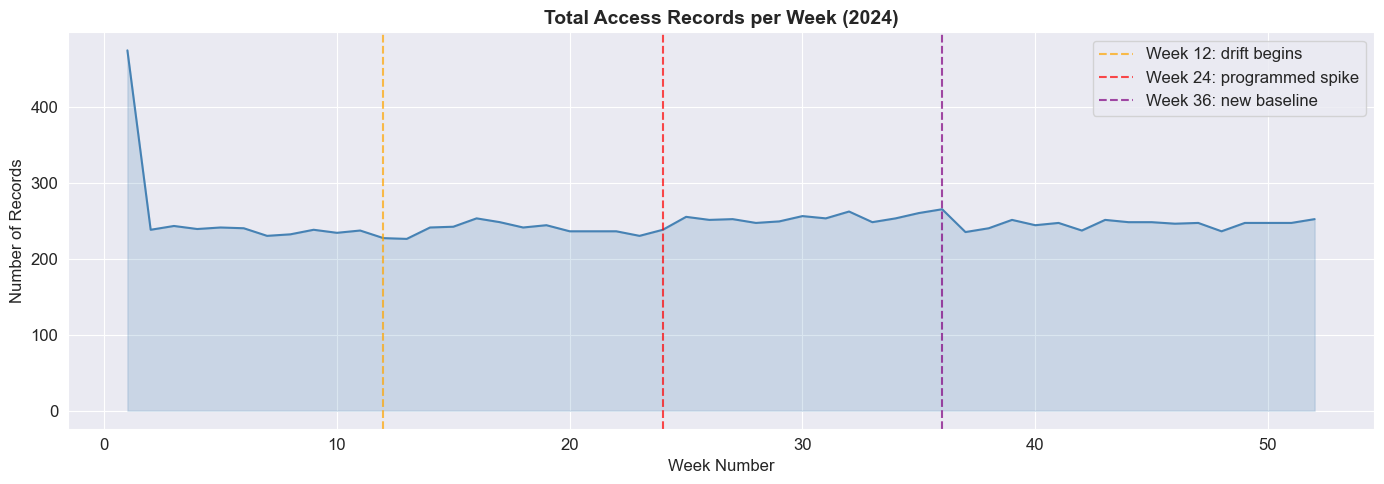

Weekly record counts (summary):
count     52.0
mean     248.4
std       33.1
min      226.0
25%      237.8
50%      245.0
75%      251.0
max      474.0
dtype: float64


In [24]:
# Extract week number from timestamp for temporal analysis
# .isocalendar().week returns ISO week numbers (1-52)
# .astype(int) needed because isocalendar returns UInt32 which 
# can cause issues with some pandas operations

df['week'] = df['timestamp'].dt.isocalendar().week.astype(int)

weekly_counts = df.groupby('week').size()

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(
    weekly_counts.index, weekly_counts.values,
    color='steelblue', linewidth=1.5
)
ax.fill_between(
    weekly_counts.index, weekly_counts.values,
    alpha=0.2, color='steelblue'
)

# Mark the weeks where the generator programmed behavioral changes
# Week 12: gradually_drifting users start increasing activity
# Week 24: sudden 30% spike programmed for gradually_drifting profile  
# Week 36: new elevated baseline kicks in for that cohort
ax.axvline(x=12, color='orange', linestyle='--', alpha=0.7, label='Week 12: drift begins')
ax.axvline(x=24, color='red', linestyle='--', alpha=0.7, label='Week 24: programmed spike')
ax.axvline(x=36, color='purple', linestyle='--', alpha=0.7, label='Week 36: new baseline')

ax.set_title('Total Access Records per Week (2024)', fontsize=14, fontweight='bold')
ax.set_xlabel('Week Number')
ax.set_ylabel('Number of Records')
ax.legend()
plt.tight_layout()
plt.show()

print(f"Weekly record counts (summary):")
print(weekly_counts.describe().round(1))

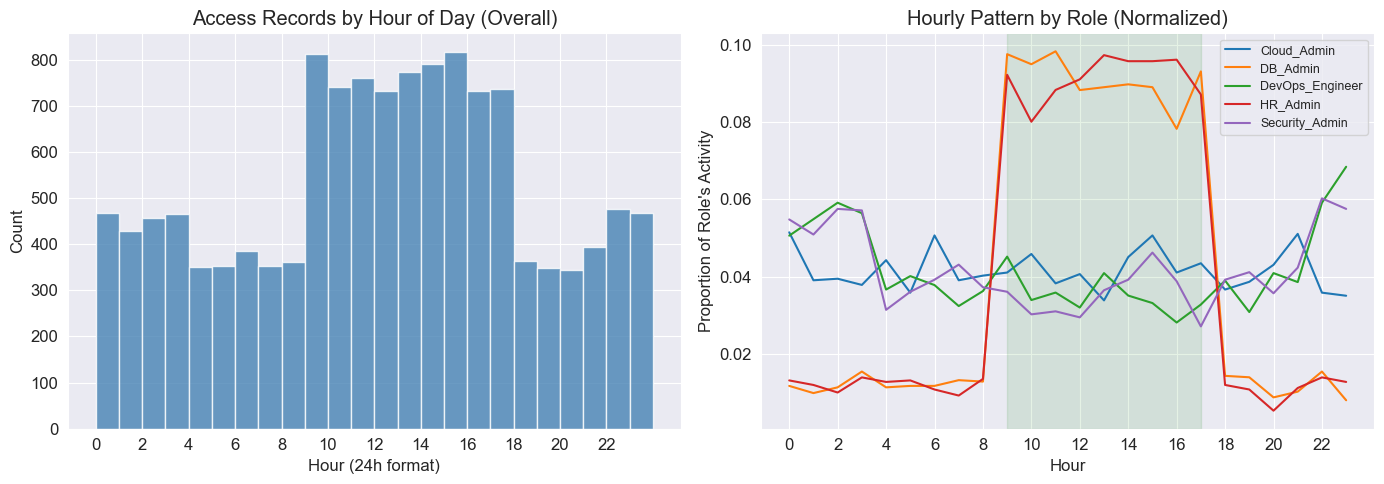

In [25]:
# Extract hour from timestamp
df['hour'] = df['timestamp'].dt.hour
df_clean_role['hour'] = df_clean_role['timestamp'].dt.hour

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LEFT: Overall - shows the general business hours pattern
axes[0].hist(
    df['hour'], bins=24, range=(0, 24),
    color='steelblue', edgecolor='white', alpha=0.8
)
axes[0].set_title('Access Records by Hour of Day (Overall)')
axes[0].set_xlabel('Hour (24h format)')
axes[0].set_ylabel('Count')
axes[0].set_xticks(range(0, 24, 2))

# RIGHT: Normalized by role shows behavioral DIFFERENCES between roles
# Normalization is critical here - without it, roles with more records
# would dominate just because of volume, hiding the pattern differences
hour_by_role = df_clean_role.groupby(
    ['role', 'hour']
).size().unstack(fill_value=0)

# Divide each row by its total so each role sums to 1.0
hour_by_role_norm = hour_by_role.div(hour_by_role.sum(axis=1), axis=0)

for role in hour_by_role_norm.index:
    axes[1].plot(
        hour_by_role_norm.columns,
        hour_by_role_norm.loc[role],
        label=role, linewidth=1.5
    )

axes[1].set_title('Hourly Pattern by Role (Normalized)')
axes[1].set_xlabel('Hour')
axes[1].set_ylabel('Proportion of Role\'s Activity')
axes[1].legend(fontsize=9)
axes[1].set_xticks(range(0, 24, 2))
# Shade business hours region for reference
axes[1].axvspan(9, 17, alpha=0.1, color='green', label='Business hours')

plt.tight_layout()
plt.show()

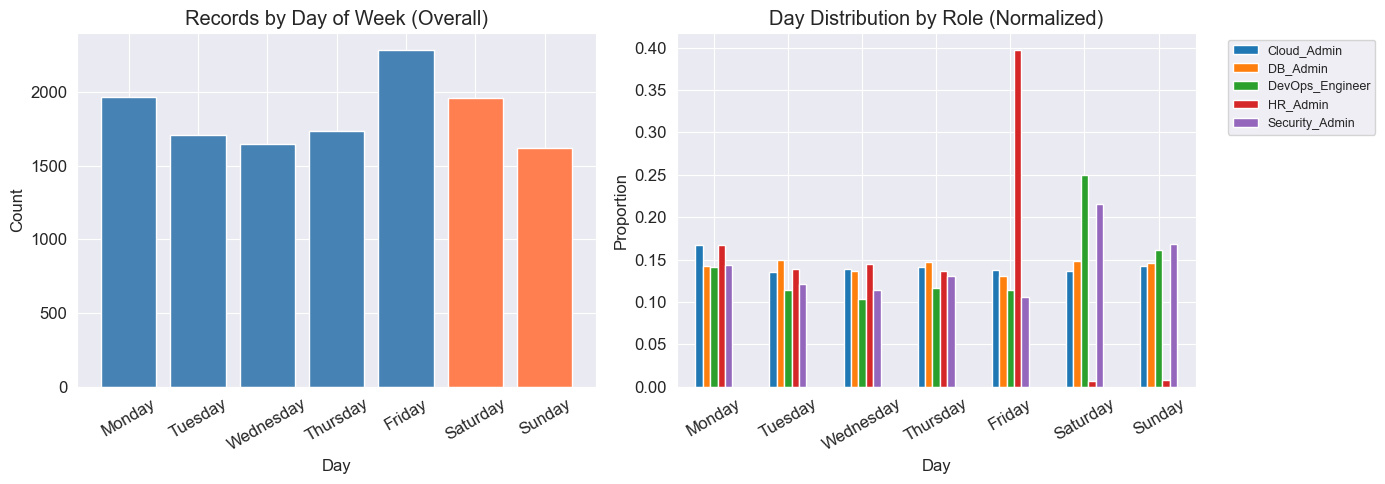

Weekend activity % by role:
role
Cloud_Admin        27.8
DB_Admin           29.4
DevOps_Engineer    41.1
HR_Admin            1.5
Security_Admin     38.4
Name: is_weekend, dtype: float64


In [26]:
# dayofweek: 0=Monday through 6=Sunday
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['day_name'] = df['timestamp'].dt.day_name()
df_clean_role['dayofweek'] = df_clean_role['timestamp'].dt.dayofweek
df_clean_role['day_name'] = df_clean_role['timestamp'].dt.day_name()

# Control the order so days appear Monday→Sunday, not alphabetically
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LEFT: Overall day distribution
day_counts = df['day_name'].value_counts().reindex(day_order)
axes[0].bar(day_order, day_counts.values, color='steelblue', edgecolor='white')
axes[0].set_title('Records by Day of Week (Overall)')
axes[0].set_xlabel('Day')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=30)

# Shade weekend columns to make them visually distinct
for i, day in enumerate(day_order):
    if day in ['Saturday', 'Sunday']:
        axes[0].patches[i].set_facecolor('coral')

# RIGHT: Normalized by role to see which roles work weekends
day_by_role = df_clean_role.groupby(
    ['role', 'day_name']
).size().unstack(fill_value=0)[day_order]
day_by_role_norm = day_by_role.div(day_by_role.sum(axis=1), axis=0)

day_by_role_norm.T.plot(kind='bar', ax=axes[1], edgecolor='white')
axes[1].set_title('Day Distribution by Role (Normalized)')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Proportion')
axes[1].tick_params(axis='x', rotation=30)
axes[1].legend(fontsize=9, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Print weekend percentages per role for precise comparison
print("Weekend activity % by role:")
df_clean_role['is_weekend'] = df_clean_role['dayofweek'] >= 5
print(df_clean_role.groupby('role')['is_weekend'].mean().mul(100).round(1))

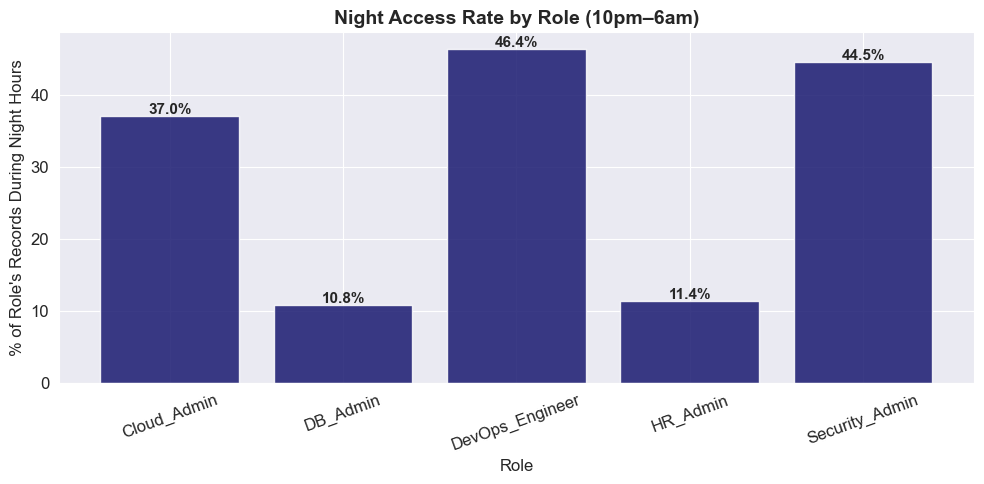

Night access counts and rates by role:
           role  night_count  night_rate  night_pct
    Cloud_Admin          927    0.370208  37.020767
       DB_Admin          291    0.107898  10.789766
DevOps_Engineer         1199    0.463650  46.365043
       HR_Admin          291    0.113672  11.367188
 Security_Admin         1145    0.445352  44.535200


In [27]:
# Night access defined as 10pm-6am (hours 22, 23, 0, 1, 2, 3, 4, 5, 6)
# DevOps and Security have legitimate night access - they're 24/7 roles
# This is important context for risk scoring: night access alone 
# shouldn't flag DevOps/Security since it's expected behavior for them

df['is_night'] = (df['hour'] >= 22) | (df['hour'] <= 6)
df_clean_role['is_night'] = (df_clean_role['hour'] >= 22) | (df_clean_role['hour'] <= 6)

night_by_role = df_clean_role.groupby('role')['is_night'].agg(
    ['sum', 'mean']
).reset_index()
night_by_role.columns = ['role', 'night_count', 'night_rate']
night_by_role['night_pct'] = night_by_role['night_rate'] * 100

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(
    night_by_role['role'], night_by_role['night_pct'],
    color='midnightblue', edgecolor='white', alpha=0.85
)
ax.set_title('Night Access Rate by Role (10pm–6am)', fontsize=14, fontweight='bold')
ax.set_ylabel('% of Role\'s Records During Night Hours')
ax.set_xlabel('Role')
ax.tick_params(axis='x', rotation=20)

# Add percentage labels above each bar
for bar, val in zip(bars, night_by_role['night_pct']):
    ax.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.3,
        f'{val:.1f}%', ha='center', fontsize=11, fontweight='bold'
    )

plt.tight_layout()
plt.show()

print("Night access counts and rates by role:")
print(night_by_role.to_string(index=False))

In [28]:
# This is the most important cell in section 5
# We collapse ~12,500 records into one row per user (100 rows total)
# All cells from 22 onwards depend on this dataframe

# Work from a clean copy with normalized columns
user_df = df.copy()
user_df['role'] = user_df['role'].str.strip()
user_df['action_lower'] = user_df['action'].str.lower()
user_df['week'] = user_df['timestamp'].dt.isocalendar().week.astype(int)
user_df['hour'] = user_df['timestamp'].dt.hour
user_df['is_night'] = (user_df['hour'] >= 22) | (user_df['hour'] <= 6)

user_summary = user_df.groupby('user_id').agg(
    role=('role', 'first'),                          # role doesn't change per user
    total_records=('user_id', 'count'),              # how active is this user overall
    assigned_resources=('assigned_resource_count', 'first'),   # what they CAN access
    used_resources=('actively_used_resource_count', 'first'),  # what they ACTUALLY access
    unique_resources_accessed=('resource_type',      # how many distinct resources touched
                                lambda x: x.str.lower().nunique()),
    export_count=('action_lower',                    # raw export count
                   lambda x: (x == 'export').sum()),
    avg_session_duration=('session_duration', 'mean'),
    avg_access_volume=('access_volume', 'mean'),
    night_access_count=('is_night', 'sum'),
).reset_index()

# Derived ratios - these are the actual risk signals
user_summary['export_ratio'] = (
    user_summary['export_count'] / user_summary['total_records']
)
user_summary['utilization_ratio'] = (
    user_summary['used_resources'] / user_summary['assigned_resources']
)
user_summary['privilege_gap'] = (
    user_summary['assigned_resources'] - user_summary['used_resources']
)

# Verify the aggregation worked correctly
print(f"User summary shape: {user_summary.shape}  ← should be (100, 12)")
print(f"\nColumn names: {list(user_summary.columns)}")
print(f"\nSanity check - unique roles: {user_summary['role'].unique()}")
print(f"\nStatistical summary:")
user_summary.describe().round(2)

User summary shape: (100, 13)  ← should be (100, 12)

Column names: ['user_id', 'role', 'total_records', 'assigned_resources', 'used_resources', 'unique_resources_accessed', 'export_count', 'avg_session_duration', 'avg_access_volume', 'night_access_count', 'export_ratio', 'utilization_ratio', 'privilege_gap']

Sanity check - unique roles: ['DB_Admin' 'HR_Admin' 'Cloud_Admin' 'Security_Admin' 'DevOps_Engineer']

Statistical summary:


,total_records,assigned_resources,used_resources,unique_resources_accessed,export_count,avg_session_duration,avg_access_volume,night_access_count,export_ratio,utilization_ratio,privilege_gap
count,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
mean,129.18,8.45,5.44,5.44,5.33,48.59,17.79,38.53,0.04,0.64,3.01
std,12.23,2.35,2.24,2.24,5.74,10.86,6.60,20.93,0.05,0.18,1.83
min,116.00,5.00,2.00,2.00,0.00,31.95,6.99,6.00,0.00,0.18,1.00
25%,122.00,6.00,4.00,4.00,2.75,38.59,13.15,16.00,0.02,0.60,2.00
50%,125.00,8.50,5.00,5.00,4.00,50.11,18.34,46.00,0.03,0.67,2.00
75%,129.00,11.00,7.00,7.00,6.00,54.85,21.06,56.00,0.05,0.78,4.00
max,166.00,12.00,11.00,11.00,33.00,66.77,35.31,75.00,0.27,0.92,9.00


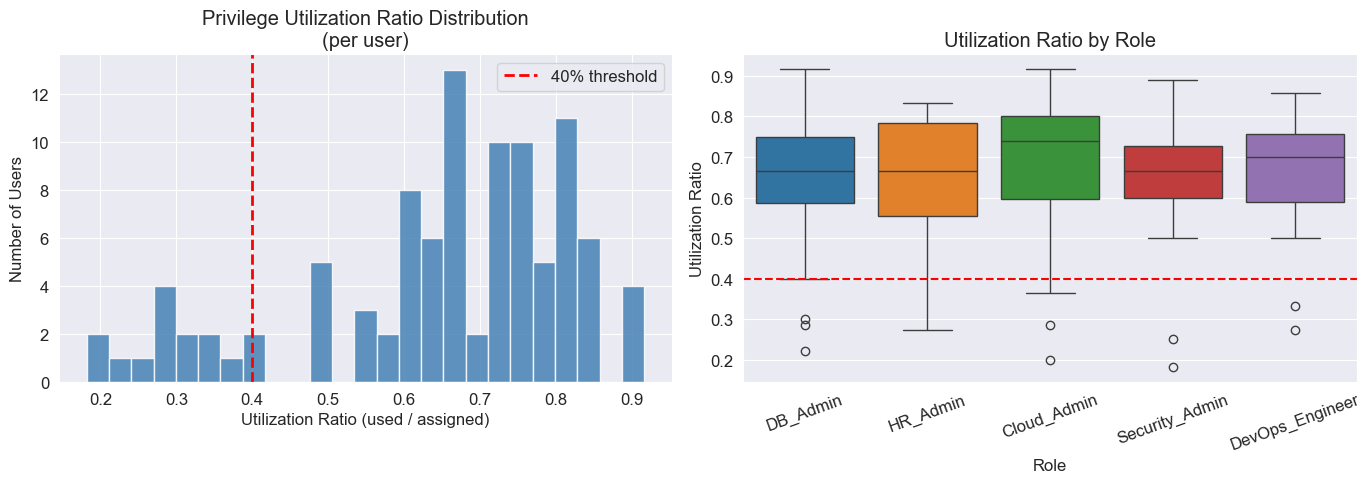

Users below 40% utilization: 13 (expected ~15)

Utilization ratio statistics:
count    100.000
mean       0.644
std        0.177
min        0.182
25%        0.596
50%        0.667
75%        0.778
max        0.917
Name: utilization_ratio, dtype: float64


In [29]:
# Utilization ratio = used_resources / assigned_resources
# A ratio of 1.0 means the user uses everything they're given
# A ratio of 0.25 means they only use 25% of what they have access to
# The 15 over-provisioned users should cluster at 0.20-0.40

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LEFT: Overall histogram with threshold line
axes[0].hist(
    user_summary['utilization_ratio'], bins=25,
    color='steelblue', edgecolor='white', alpha=0.85
)
# 40% threshold - below this is considered "over-provisioned" 
# based on the generator's config (0.20-0.40 range for that profile)
axes[0].axvline(
    x=0.40, color='red', linestyle='--', linewidth=2,
    label='40% threshold'
)
axes[0].set_title('Privilege Utilization Ratio Distribution\n(per user)')
axes[0].set_xlabel('Utilization Ratio (used / assigned)')
axes[0].set_ylabel('Number of Users')
axes[0].legend()

# RIGHT: Box plot by role - are over-provisioned users in specific roles?
sns.boxplot(
    data=user_summary, x='role', y='utilization_ratio',
    ax=axes[1], palette='tab10'
)
axes[1].set_title('Utilization Ratio by Role')
axes[1].set_xlabel('Role')
axes[1].set_ylabel('Utilization Ratio')
axes[1].tick_params(axis='x', rotation=20)
axes[1].axhline(y=0.40, color='red', linestyle='--', linewidth=1.5)

plt.tight_layout()
plt.show()

# Count over-provisioned users
over_provisioned = (user_summary['utilization_ratio'] < 0.40).sum()
print(f"Users below 40% utilization: {over_provisioned} (expected ~15)")
print(f"\nUtilization ratio statistics:")
print(user_summary['utilization_ratio'].describe().round(3))

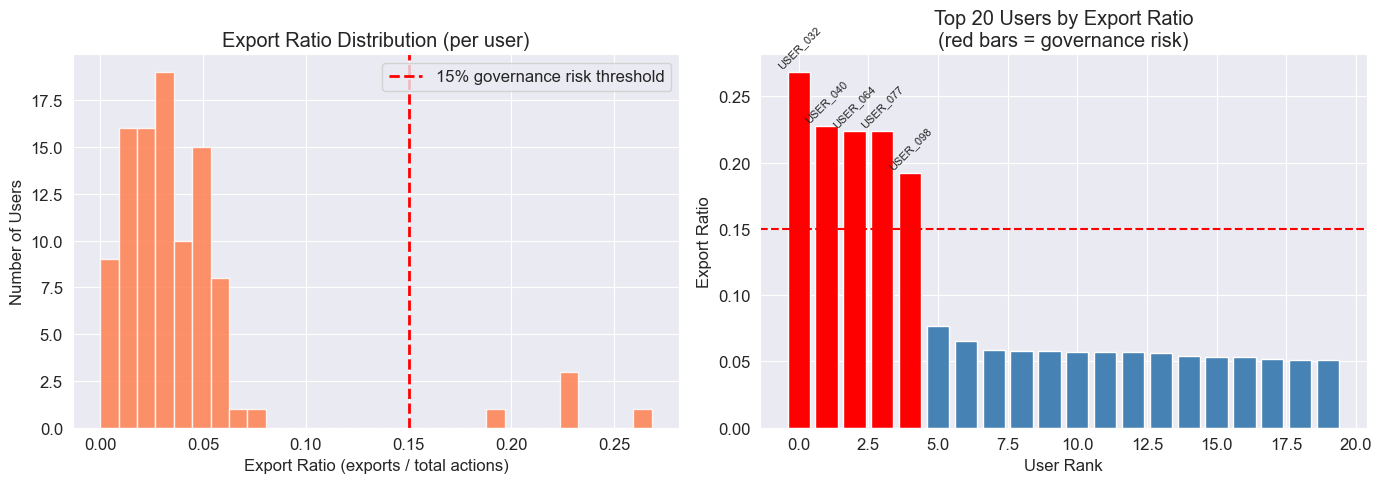

Users above 15% export ratio: 5 (expected ~5)

High-export users:
 user_id            role  export_ratio  export_count  total_records
USER_032        HR_Admin      0.268293            33            123
USER_040        HR_Admin      0.227642            28            123
USER_064  Security_Admin      0.224000            28            125
USER_077  Security_Admin      0.224000            28            125
USER_098 DevOps_Engineer      0.192308            25            130


In [30]:
# Export ratio = export_count / total_records for each user
# Normal users: 2-5% exports (governed by the generator's config)
# Export-heavy users: 18-28% exports (governance risk profile)
# These 5 users should be clearly isolated from the rest

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LEFT: Histogram - should show almost everyone below 10%
# with 5 outliers far to the right
axes[0].hist(
    user_summary['export_ratio'], bins=30,
    color='coral', edgecolor='white', alpha=0.85
)
axes[0].axvline(
    x=0.15, color='red', linestyle='--', linewidth=2,
    label='15% governance risk threshold'
)
axes[0].set_title('Export Ratio Distribution (per user)')
axes[0].set_xlabel('Export Ratio (exports / total actions)')
axes[0].set_ylabel('Number of Users')
axes[0].legend()

# RIGHT: Sorted bar chart - shows individual outliers clearly
# Color each bar red if above threshold, blue if below
user_export_sorted = user_summary.sort_values('export_ratio', ascending=False).head(20)
colors = ['red' if r > 0.15 else 'steelblue' 
          for r in user_export_sorted['export_ratio']]

axes[1].bar(
    range(len(user_export_sorted)),
    user_export_sorted['export_ratio'],
    color=colors, edgecolor='white'
)
axes[1].axhline(y=0.15, color='red', linestyle='--', linewidth=1.5)
axes[1].set_title('Top 20 Users by Export Ratio\n(red bars = governance risk)')
axes[1].set_xlabel('User Rank')
axes[1].set_ylabel('Export Ratio')

# Label the high-risk user IDs
for i, (_, row) in enumerate(user_export_sorted.head(7).iterrows()):
    if row['export_ratio'] > 0.15:
        axes[1].text(i, row['export_ratio'] + 0.003, 
                    row['user_id'], ha='center', fontsize=8, rotation=45)

plt.tight_layout()
plt.show()

high_export_users = user_summary[user_summary['export_ratio'] > 0.15]
print(f"Users above 15% export ratio: {len(high_export_users)} (expected ~5)")
print(f"\nHigh-export users:")
print(high_export_users[['user_id', 'role', 'export_ratio', 
                          'export_count', 'total_records']].to_string(index=False))

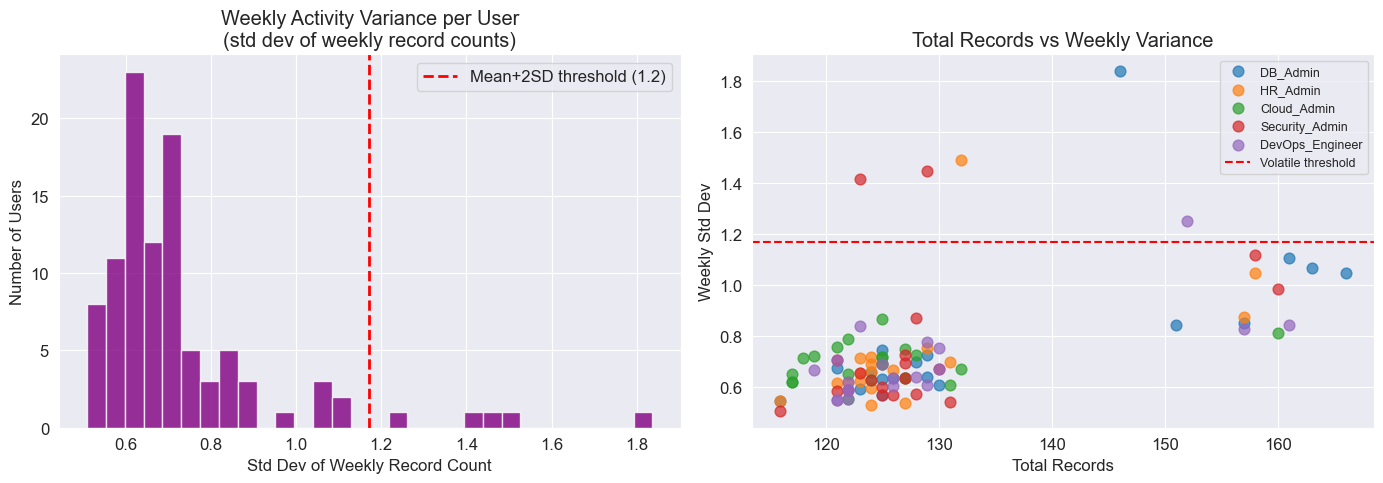

High-variance (volatile) users: 5 (expected ~5)


In [31]:
# Volatile users have high week-to-week variance in their activity
# We compute the standard deviation of weekly record counts per user
# Users with std dev far above the mean are the 5 volatile users

# First compute weekly record counts per user
weekly_per_user = user_df.groupby(
    ['user_id', 'week']
).size().reset_index(name='weekly_count')

# Then compute the standard deviation of those weekly counts
user_weekly_variance = weekly_per_user.groupby(
    'user_id'
)['weekly_count'].std().reset_index()
user_weekly_variance.columns = ['user_id', 'weekly_std']

# Merge in role for color coding
user_weekly_variance = user_weekly_variance.merge(
    user_summary[['user_id', 'role']], on='user_id'
)

# Define "high variance" as more than 2 standard deviations above the mean
mean_std = user_weekly_variance['weekly_std'].mean()
sd_std = user_weekly_variance['weekly_std'].std()
volatile_threshold = mean_std + 2 * sd_std

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LEFT: Distribution of variance across all users
axes[0].hist(
    user_weekly_variance['weekly_std'], bins=30,
    color='purple', edgecolor='white', alpha=0.8
)
axes[0].axvline(
    x=volatile_threshold, color='red', linestyle='--', linewidth=2,
    label=f'Mean+2SD threshold ({volatile_threshold:.1f})'
)
axes[0].set_title('Weekly Activity Variance per User\n(std dev of weekly record counts)')
axes[0].set_xlabel('Std Dev of Weekly Record Count')
axes[0].set_ylabel('Number of Users')
axes[0].legend()

# RIGHT: Scatter showing variance vs total records, colored by role
for role in user_weekly_variance['role'].unique():
    mask = user_weekly_variance['role'] == role
    subset = user_weekly_variance[mask].merge(
        user_summary[['user_id', 'total_records']], on='user_id'
    )
    axes[1].scatter(
        subset['total_records'], subset['weekly_std'],
        label=role, alpha=0.7, s=60
    )

axes[1].axhline(
    y=volatile_threshold, color='red', linestyle='--', linewidth=1.5,
    label='Volatile threshold'
)
axes[1].set_title('Total Records vs Weekly Variance')
axes[1].set_xlabel('Total Records')
axes[1].set_ylabel('Weekly Std Dev')
axes[1].legend(fontsize=9)

plt.tight_layout()
plt.show()

volatile_users = (user_weekly_variance['weekly_std'] > volatile_threshold).sum()
print(f"High-variance (volatile) users: {volatile_users} (expected ~5)")

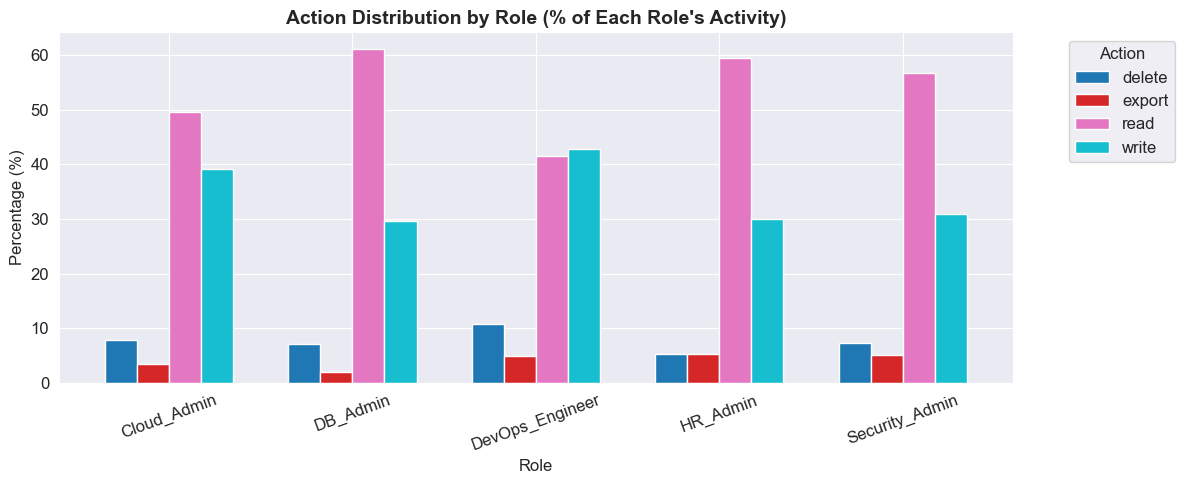

Action distribution by role (%):
action_lower     delete  export  read  write
role                                        
Cloud_Admin         7.8     3.4  49.6   39.1
DB_Admin            7.1     2.1  61.1   29.7
DevOps_Engineer    10.8     4.9  41.5   42.8
HR_Admin            5.4     5.2  59.5   30.0
Security_Admin      7.3     5.1  56.7   30.9

Generator's programmed weights for reference:
DB_Admin:        read=60%, write=32%, delete=6%, export=2%
HR_Admin:        read=65%, write=28%, delete=4%, export=3%
Cloud_Admin:     read=50%, write=38%, delete=9%, export=3%
Security_Admin:  read=60%, write=30%, delete=7%, export=3%
DevOps_Engineer: read=40%, write=45%, delete=11%, export=4%


In [32]:
# Compare the action mix across roles - the generator programmed 
# different action weights per role, so each role should have a 
# different fingerprint (DevOps most write-heavy, HR_Admin most read-heavy)
# Peer-deviant users (8 of them) will slightly distort their role's bars
# because they act like a different role

action_by_role = user_df.groupby(
    ['role', 'action_lower']
).size().unstack(fill_value=0)

# Normalize to percentages so roles with different record volumes
# are directly comparable
action_by_role_pct = action_by_role.div(
    action_by_role.sum(axis=1), axis=0
) * 100

fig, ax = plt.subplots(figsize=(12, 5))
action_by_role_pct.plot(
    kind='bar', ax=ax, edgecolor='white',
    colormap='tab10', width=0.7
)
ax.set_title('Action Distribution by Role (% of Each Role\'s Activity)',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Role')
ax.set_ylabel('Percentage (%)')
ax.tick_params(axis='x', rotation=20)
ax.legend(title='Action', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Print exact percentages for comparison against generator's programmed weights
print("Action distribution by role (%):")
print(action_by_role_pct.round(1))
print("\nGenerator's programmed weights for reference:")
print("DB_Admin:        read=60%, write=32%, delete=6%, export=2%")
print("HR_Admin:        read=65%, write=28%, delete=4%, export=3%")
print("Cloud_Admin:     read=50%, write=38%, delete=9%, export=3%")
print("Security_Admin:  read=60%, write=30%, delete=7%, export=3%")
print("DevOps_Engineer: read=40%, write=45%, delete=11%, export=4%")

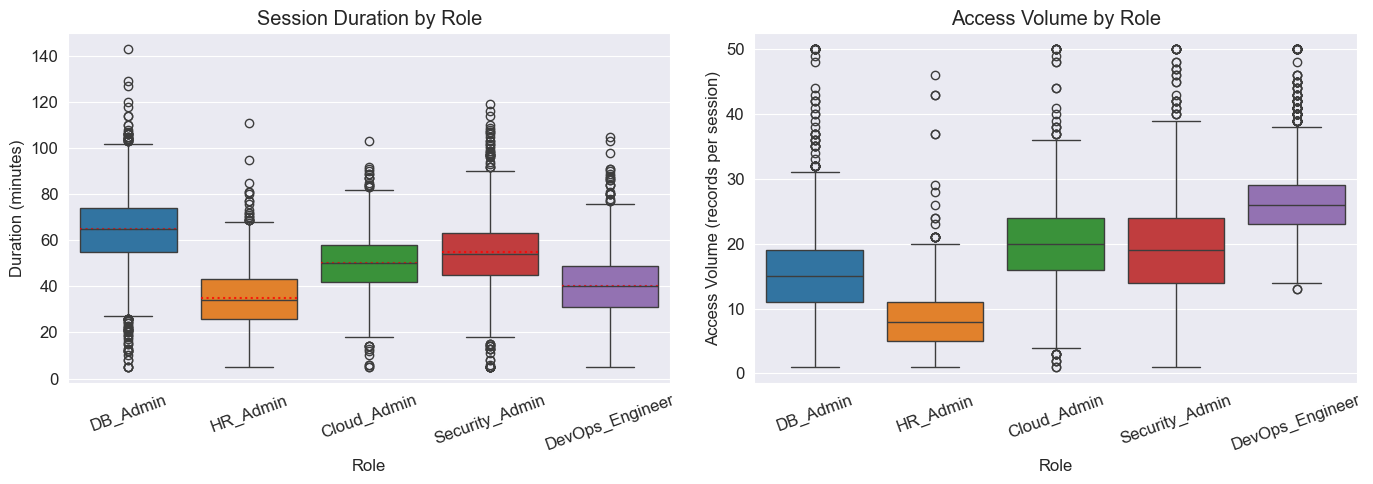

Median session duration by role:
role
Cloud_Admin        50.0
DB_Admin           65.0
DevOps_Engineer    40.0
HR_Admin           34.0
Security_Admin     54.0
Name: session_duration, dtype: float64

Median access volume by role:
role
Cloud_Admin        20.0
DB_Admin           15.0
DevOps_Engineer    26.0
HR_Admin            8.0
Security_Admin     19.0
Name: access_volume, dtype: float64


In [33]:
# Box plots show the distribution shape (median, spread, outliers)
# not just the mean - which matters because volatile users create outliers

roles_order = ['DB_Admin', 'HR_Admin', 'Cloud_Admin', 
               'Security_Admin', 'DevOps_Engineer']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LEFT: Session duration - DB_Admin baseline is 65 mins, HR_Admin is 35
sns.boxplot(
    data=df_clean_role,
    x='role', y='session_duration',
    order=roles_order, ax=axes[0],
    palette='tab10'
)
axes[0].set_title('Session Duration by Role')
axes[0].set_xlabel('Role')
axes[0].set_ylabel('Duration (minutes)')
axes[0].tick_params(axis='x', rotation=20)

# Add horizontal reference lines at the generator's programmed baselines
baselines_duration = {'DB_Admin': 65, 'HR_Admin': 35, 'Cloud_Admin': 50,
                      'Security_Admin': 55, 'DevOps_Engineer': 40}
for i, role in enumerate(roles_order):
    axes[0].axhline(
        y=baselines_duration[role], xmin=(i)/5+0.02, xmax=(i+1)/5-0.02,
        color='red', linestyle=':', linewidth=1.5, alpha=0.8
    )

# RIGHT: Access volume - DevOps baseline is 25, HR_Admin is 8
sns.boxplot(
    data=df_clean_role,
    x='role', y='access_volume',
    order=roles_order, ax=axes[1],
    palette='tab10'
)
axes[1].set_title('Access Volume by Role')
axes[1].set_xlabel('Role')
axes[1].set_ylabel('Access Volume (records per session)')
axes[1].tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.show()

print("Median session duration by role:")
print(df_clean_role.groupby('role')['session_duration'].median().round(1))
print("\nMedian access volume by role:")
print(df_clean_role.groupby('role')['access_volume'].median().round(1))

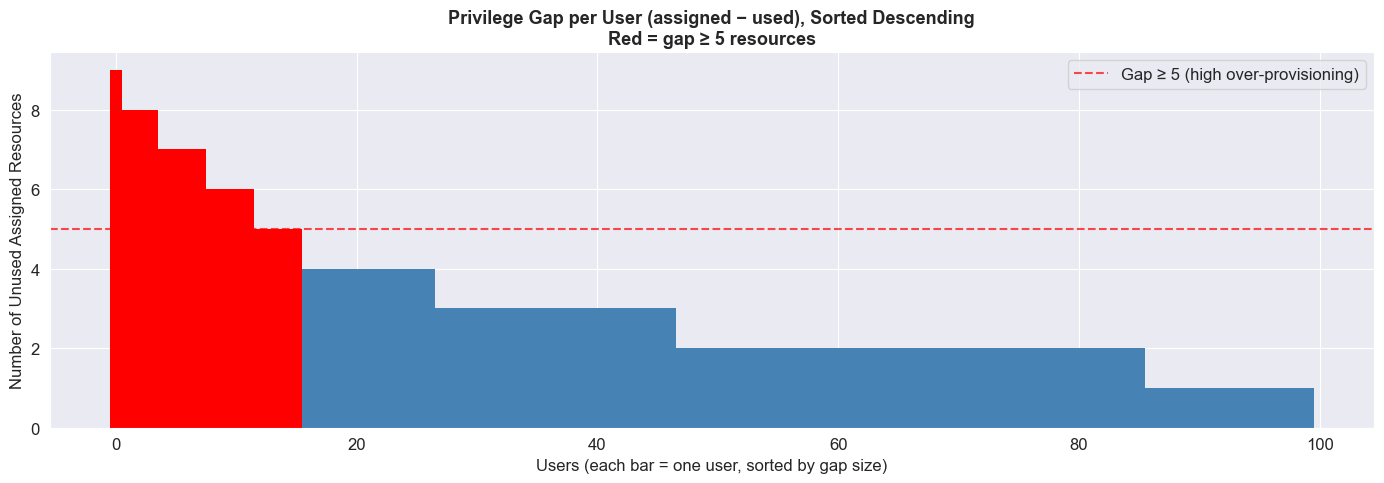

Users with gap ≥ 5 resources: 16 (expected ~15)

Gap statistics:
count    100.0
mean       3.0
std        1.8
min        1.0
25%        2.0
50%        2.0
75%        4.0
max        9.0
Name: privilege_gap, dtype: float64


In [34]:
# Visualize the raw gap (assigned - used) per user sorted from largest to smallest
# Over-provisioned users should dominate the top of this chart
# A gap of 0 means the user uses every resource they're given

user_summary_sorted = user_summary.sort_values(
    'privilege_gap', ascending=False
).reset_index(drop=True)

# Color bars red if gap >= 5, suggesting significant over-provisioning
colors = ['red' if g >= 5 else 'steelblue' 
          for g in user_summary_sorted['privilege_gap']]

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(
    range(len(user_summary_sorted)),
    user_summary_sorted['privilege_gap'],
    color=colors, edgecolor='none', width=1.0
)
ax.axhline(y=5, color='red', linestyle='--', linewidth=1.5, alpha=0.7,
           label='Gap ≥ 5 (high over-provisioning)')
ax.set_title('Privilege Gap per User (assigned − used), Sorted Descending\n'
             'Red = gap ≥ 5 resources', fontsize=13, fontweight='bold')
ax.set_xlabel('Users (each bar = one user, sorted by gap size)')
ax.set_ylabel('Number of Unused Assigned Resources')
ax.legend()

plt.tight_layout()
plt.show()

large_gap = (user_summary_sorted['privilege_gap'] >= 5).sum()
print(f"Users with gap ≥ 5 resources: {large_gap} (expected ~15)")
print(f"\nGap statistics:")
print(user_summary['privilege_gap'].describe().round(1))

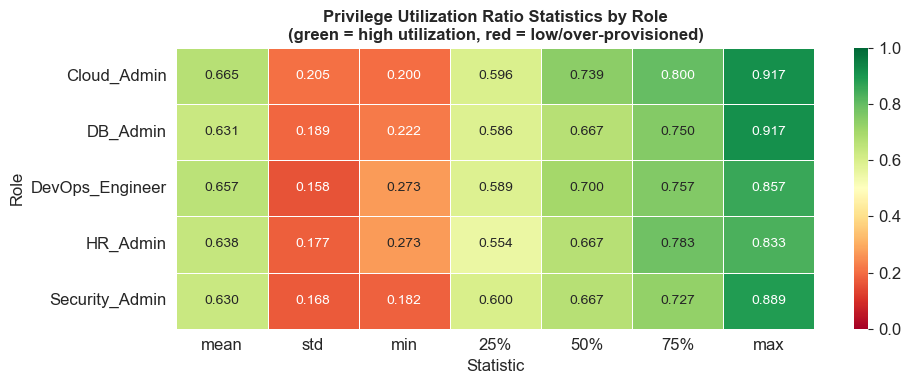

                  mean    std    min    25%    50%    75%    max
role                                                            
Cloud_Admin      0.665  0.205  0.200  0.596  0.739  0.800  0.917
DB_Admin         0.631  0.189  0.222  0.586  0.667  0.750  0.917
DevOps_Engineer  0.657  0.158  0.273  0.589  0.700  0.757  0.857
HR_Admin         0.638  0.177  0.273  0.554  0.667  0.783  0.833
Security_Admin   0.630  0.168  0.182  0.600  0.667  0.727  0.889


In [35]:
# Summarize utilization statistics per role in a heatmap
# Shows whether over-provisioned users are spread across roles
# or concentrated in specific ones
# Green = high utilization (good), Red = low utilization (over-provisioned)

util_by_role = user_summary.groupby('role')['utilization_ratio'].describe()[
    ['mean', 'std', 'min', '25%', '50%', '75%', 'max']
].round(3)

fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(
    util_by_role,
    annot=True, fmt='.3f',
    cmap='RdYlGn',       # Red=low, Yellow=middle, Green=high
    linewidths=0.5,
    ax=ax,
    vmin=0, vmax=1,       # Anchor the color scale to 0-1
    annot_kws={'size': 10}
)
ax.set_title('Privilege Utilization Ratio Statistics by Role\n'
             '(green = high utilization, red = low/over-provisioned)',
             fontsize=12, fontweight='bold')
ax.set_xlabel('Statistic')
ax.set_ylabel('Role')
plt.tight_layout()
plt.show()

print(util_by_role)

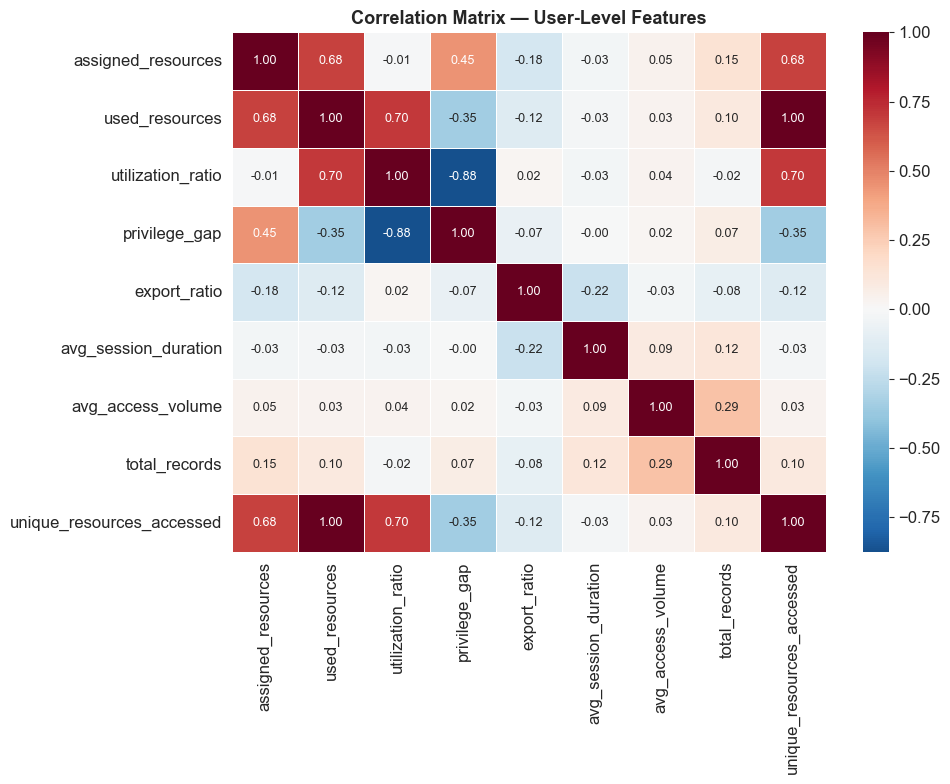

Notable correlations:
Top positive:
utilization_ratio          used_resources        0.703
unique_resources_accessed  assigned_resources    0.683
privilege_gap              assigned_resources    0.448
avg_access_volume          total_records         0.293
total_records              assigned_resources    0.149
dtype: float64

Top negative:
export_ratio    assigned_resources          -0.176
                avg_session_duration        -0.222
used_resources  privilege_gap               -0.347
privilege_gap   unique_resources_accessed   -0.347
                utilization_ratio           -0.875
dtype: float64


In [36]:
# Correlation matrix between user-level features
# Helps identify which features move together
# Strong correlations might indicate redundant features for modeling later

corr_cols = [
    'assigned_resources',        # what they can access
    'used_resources',            # what they actually access
    'utilization_ratio',         # used/assigned
    'privilege_gap',             # assigned - used
    'export_ratio',              # exports / total actions
    'avg_session_duration',      # mean session length
    'avg_access_volume',         # mean records per session
    'total_records',             # overall activity level
    'unique_resources_accessed'  # breadth of resource usage
]

corr_matrix = user_summary[corr_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True, fmt='.2f',
    cmap='RdBu_r',          # Red=negative, Blue=positive correlation
    center=0,               # White = zero correlation
    linewidths=0.5,
    ax=ax,
    annot_kws={'size': 9}
)
ax.set_title('Correlation Matrix — User-Level Features',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Call out the most interesting correlations
print("Notable correlations:")
corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
# Remove self-correlations (which are always 1.0)
corr_pairs = corr_pairs[corr_pairs < 1.0].drop_duplicates()
print("Top positive:")
print(corr_pairs.head(5).round(3))
print("\nTop negative:")
print(corr_pairs.tail(5).round(3))

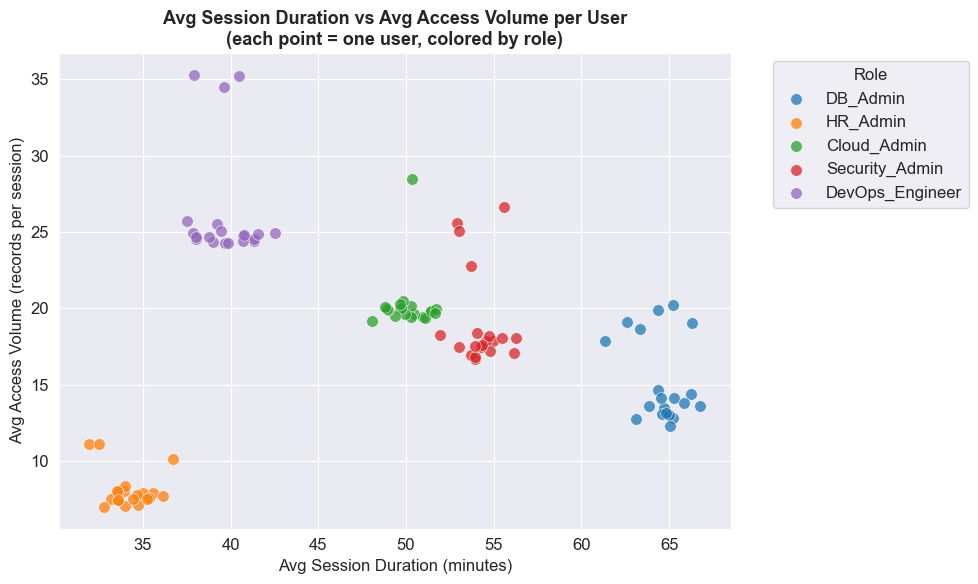

Avg session duration and volume by role:
                 avg_session_duration  avg_access_volume
role                                                    
Cloud_Admin                      50.1               20.2
DB_Admin                         64.6               15.2
DevOps_Engineer                  39.7               26.3
HR_Admin                         34.2                8.1
Security_Admin                   54.3               19.1


In [37]:
# Final scatter to visualize role-level clustering in behavioral space
# Each dot = one user, colored by role
# If roles behave differently (which they should), you'll see clusters

fig, ax = plt.subplots(figsize=(10, 6))

palette = dict(zip(
    user_summary['role'].unique(),
    sns.color_palette('tab10', user_summary['role'].nunique())
))

for role in user_summary['role'].unique():
    mask = user_summary['role'] == role
    ax.scatter(
        user_summary.loc[mask, 'avg_session_duration'],
        user_summary.loc[mask, 'avg_access_volume'],
        label=role, alpha=0.75, s=70,
        color=palette[role], edgecolors='white', linewidth=0.5
    )

ax.set_title('Avg Session Duration vs Avg Access Volume per User\n'
             '(each point = one user, colored by role)',
             fontsize=13, fontweight='bold')
ax.set_xlabel('Avg Session Duration (minutes)')
ax.set_ylabel('Avg Access Volume (records per session)')
ax.legend(title='Role', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

print("Avg session duration and volume by role:")
print(user_summary.groupby('role')[
    ['avg_session_duration', 'avg_access_volume']
].mean().round(1))

## EDA Summary — Key Findings

### Data Quality Issues (fix in `02_data_cleaning.ipynb`)
| Issue | Column | Scale |
|---|---|---|
| Missing values | `session_duration`, `access_volume` | ~3% each |
| Duplicate rows | All | ~2% |
| Uppercase strings | `resource_type` | ~10% |
| Whitespace padding | `role` | ~5% |
| Mixed case | `action` | ~8% |

---

### Behavioral Signals Confirmed

**Over-provisioning (15 users)**  
Clearly visible as a separate cluster at 0.20–0.40 utilization ratio.
The scatter plot in cell 15 shows these users sitting well below the 
perfect-utilization diagonal.

**Export risk (5 users)**  
A clean gap separates the 5 export-heavy users (18–28% export ratio) 
from the rest of the population (2–5%). No gradual tail — a discrete outlier group.

**Volatile behavior (5 users)**  
Identifiable via weekly activity standard deviation. These users don't 
necessarily have more total records — they're just erratic week to week.

**Gradual drift**  
Subtly visible in the weekly totals chart — slightly elevated record 
counts from week 24 onward due to 12 gradually_drifting users.

---

### Role Behavioral Profiles Confirmed
- **HR_Admin**: near-exclusively business hours and weekdays
- **DevOps_Engineer + Security_Admin**: measurable night (~15%) and weekend (~18%) access — legitimate by role design, should NOT be flagged as anomalous in isolation
- **Action mix**: each role has a distinct fingerprint matching the generator's programmed weights
- **Session duration and volume**: clear role-level differences, useful for peer comparison features

---

### Implications for Feature Engineering (`03_feature_engineering.ipynb`)
- `utilization_ratio` = core misalignment feature, already computed
- `export_ratio` must be computed per-user, not globally
- Role-normalized z-scores needed to detect peer deviation fairly
- Temporal features (is_night, is_weekend, hour, week) confirmed meaningful
- `privilege_gap` is a direct governance input